In [71]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

In [72]:
class Linear():
    def __init__(self, in_features: int, out_features: int, batch_size: int, lr=0.1):
        super(Linear, self).__init__()
        self.batch_size = batch_size
        self.lr = lr
        self.weight = torch.randn(in_features, out_features) * np.sqrt(1. / in_features)
        self.bias = torch.randn(out_features) * np.sqrt(1. / in_features)
        self.grad_weight = torch.zeros(in_features, out_features)
        self.grad_bias = torch.zeros(out_features)
        self.input = torch.zeros(batch_size, in_features)

    def forward(self, input):
        self.input = input
        output = torch.mm(input, self.weight) + self.bias
        return output

    def backward(self, grad_output):
        grad_input = torch.mm(grad_output, self.weight.t())
        self.grad_weight = torch.mm(self.input.t(), grad_output)
        self.grad_bias = grad_output.sum(dim=0)
        return grad_input

    def update(self):
        self.weight -= self.lr * self.grad_weight
        self.bias -= self.lr * self.grad_bias

In [73]:
class Sigmoid():
    def __init__(self, in_features: int, batch_size: int):
        super(Sigmoid, self).__init__()
        self.input = torch.zeros(batch_size)

    def forward(self, input):
        self.input = input
        output = 1 / (1 + torch.exp(-input))
        return output

    def backward(self, grad_output):
        grad_input = grad_output * (1 - self.forward(self.input)) * self.forward(self.input)
        return grad_input

In [74]:
def Softmax(input):
    output = torch.exp(input) / torch.exp(input).sum(dim=1, keepdim=True)
    return output

def compute_loss(target, prediction):
    return -torch.sum(target * torch.log(prediction))/prediction.shape[0]

def compute_gradient(target, prediction):
    return (prediction - target)

In [75]:
class MLP():
    def __init__(self, batch_size, lr):
        super(MLP, self).__init__()
        self.linear0 = Linear(28*28, 512, batch_size, lr)
        self.sigmoid0 = Sigmoid(512, batch_size)
        self.linear1 = Linear(512, 128, batch_size, lr)
        self.sigmoid1 = Sigmoid(128, batch_size)
        self.linear2 = Linear(128, 10, batch_size, lr)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear0.forward(x)
        x = self.sigmoid0.forward(x)
        x = self.linear1.forward(x)
        x = self.sigmoid1.forward(x)
        x = self.linear2.forward(x)
        x = Softmax(x)
        return x

    def backward(self, x):
        x = self.linear2.backward(x)
        x = self.sigmoid1.backward(x)
        x = self.linear1.backward(x)
        x = self.sigmoid0.backward(x)
        x = self.linear0.backward(x)

    def update(self):
        self.linear0.update()
        self.linear1.update()
        self.linear2.update()

In [76]:
test_accuracies_0_1 = []
test_accuracies_00_1 = []
test_accuracies_000_1 = []
test_accuracies_00_5 = []
test_accuracies_000_5 = []

In [77]:
def train(args, model, train_loader, epoch):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model.forward(data)
        loss = compute_loss(target, output)
        gradient = compute_gradient(target, output)
        model.backward(gradient)
        model.update()
        train_loss += loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.shape[0]))
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

In [78]:
def test(args, model, test_loader, epoch):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model.forward(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
       
        target = F.one_hot(target)
        loss = compute_loss(target, output)
        test_loss += loss

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    print('\nTest Epoch: {} Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [79]:
train_losses = []
test_losses = []
test_accuracies = []
%config IPKernelApp.kernel_args=""

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N', help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=30, metavar='N', help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='learning rate (default: 0.1)')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N', help='how many batches to wait before logging training status')
args = parser.parse_args(args=[])

torch.manual_seed(args.seed)

transform=transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data', train=True, download=True, transform=transform, target_transform=torchvision.transforms.Compose([ lambda x:torch.LongTensor([x]), lambda x:F.one_hot(x, 10),lambda x:x.squeeze()]))
dataset_test = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size = args.batch_size)
test_loader = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size = args.batch_size)

with torch.no_grad():
  model = MLP(args.batch_size, args.lr)
  for epoch in range(1, args.epochs + 1):
    train(args, model, train_loader, epoch)
    test(args, model, test_loader, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.039218
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.034091
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.032002
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.022998
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.018240
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.017589
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.013945
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.012096
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.013381
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.007258
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.009356
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.005688
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.010367
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.004687
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.009168
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.005778
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.005621
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.010458
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.008745
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.005683
Train Epoch: 1 [12800/60000 (

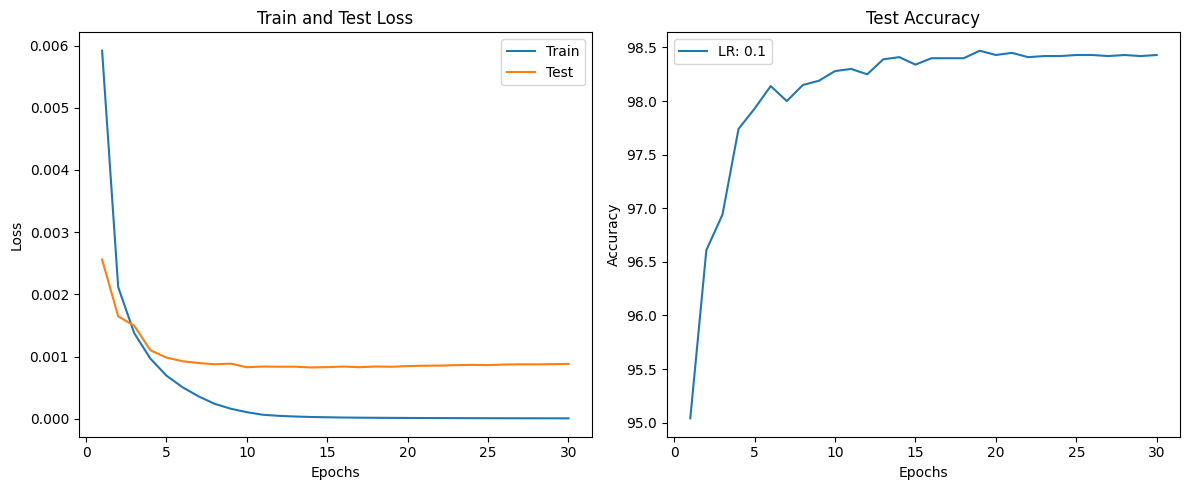

In [80]:
epochs = range(1, args.epochs + 1)

plt.figure(figsize=(12, 5))

# # Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='LR: 0.1')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()